# Operational Limits

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import seaborn as sns

from scipy.special import xlogy

from validate import *

from scipy.stats import wilcoxon

plt.style.use('utils\plotstyle.mplstyle')

## Load Data

In [2]:
folder = ''
model = 'ViT_B_32_ENSEMBLE_ISOTONIC'  # change model here
path_experiments = f'experiments\\{folder}\\{model}'

filename_original = 'ensemble_10_results.pkl'

filename_ = f'train_{filename_original}'
filename_ = 'ensemble_10_train_results.pkl'

with open(os.path.join(path_experiments,filename_original), 'rb') as f:
    dataframe_original = pd.DataFrame(pickle.load(f))

with open(os.path.join(path_experiments,filename_), 'rb') as f:
    dataframe_calib = pd.DataFrame(pickle.load(f))

In [3]:
dataframe_original['corrects'] = dataframe_original['labels'] == dataframe_original['preds']
dataframe_calib['corrects'] = dataframe_calib['labels'] == dataframe_calib['preds']

dataframe_original['stds'] = dataframe_original['probs_uq'].apply(lambda x: np.std(x, axis=0))
dataframe_calib['stds'] = dataframe_calib['probs_uq'].apply(lambda x: np.std(x, axis=0))

## Original Metrics

In [4]:
# ---------- helpers ----------------------------------------------------------
def _replace_nan_with_fold_mean(arr: np.ndarray) -> None:
    """In-place: replace NaNs by the nan-mean of the same array."""
    nan_mask = np.isnan(arr)
    if nan_mask.any():
        arr[nan_mask] = np.nanmean(arr)

def _init_metric_dict(names, n):
    """Create {metric: np.full(n, np.nan)}."""
    return {k: np.full(n, np.nan) for k in names}


def metrics_values_to_csv(
    metric_dict: dict[str, np.ndarray],
    metric_order: list[str] | None = ["Accuracy", "F1 Score","Precision", "Sensitivity","Specificity", "AUC", "ECE", "MCE", "NLL", "Brier"],
    nan_placeholder: str = ""
) -> str:
   
    if metric_order is None:
        metric_order = list(metric_dict.keys())

    def _fmt(v: float) -> str:
        if np.isnan(v):
            return nan_placeholder
        return f"{v:.4f}".replace(".", ",")

    lines = [
        ";".join(_fmt(x) for x in metric_dict[m])
        for m in metric_order
    ]
    return "\n".join(lines)


In [5]:
n_bins = 10
mode_metrics = 'quantile'
mode_plot    = 'uniform'

In [6]:
# -----------------------------------------------------------------------------
# Original predictions (no confidence limits)
# -----------------------------------------------------------------------------
fold_groups   = dataframe_original.groupby('fold', sort=False)
n_folds       = fold_groups.ngroups

perf_names  = ["Accuracy", "F1 Score", "Precision",
               "Sensitivity", "Specificity", "AUC"]
calib_names = ["ECE", "MCE", "NLL", "Brier"]

metrics_orig = _init_metric_dict(perf_names + calib_names, n_folds)

for idx, (_, df) in enumerate(fold_groups):
    # -------- performance ----------------------------------------------------
    p = validation_metrics(df['preds'], df['probs'], df['labels'])
    for k in perf_names:
        metrics_orig[k][idx] = p[k]

    # -------- calibration ----------------------------------------------------
    c = calibration_metrics(df['probs'], df['labels'],
                            n_bins=n_bins, mode=mode_metrics)
    for k in calib_names:
        metrics_orig[k][idx] = c[k]

# Fill any accidental NaNs with the per-metric fold mean
for arr in metrics_orig.values():
    _replace_nan_with_fold_mean(arr)

# --------------------------- pretty print ------------------------------------
def _show(name, arr):
    print(f"{name:<14}= {arr.mean():.4f} ± {arr.std():.2f}")

print("\n--- Performance (original predictions) ------------------------")
for k in perf_names:
    _show(k, metrics_orig[k])

print("\n--- Calibration ----------------------------------------------")
for k in calib_names:
    _show(k, metrics_orig[k])



--- Performance (original predictions) ------------------------
Accuracy      = 0.8265 ± 0.06
F1 Score      = 0.7972 ± 0.06
Precision     = 0.8622 ± 0.06
Sensitivity   = 0.7495 ± 0.10
Specificity   = 0.8859 ± 0.08
AUC           = 0.8979 ± 0.05

--- Calibration ----------------------------------------------
ECE           = 0.1064 ± 0.03
MCE           = 0.3255 ± 0.14
NLL           = 0.4174 ± 0.14
Brier         = 0.1268 ± 0.04


## Prepare DataFrame

In [7]:
dataframe_calib

,fold,img_names,labels,probs,probs_uq,preds,corrects,stds
0,0,Datasets\Folds\0\Train\00_AUG_ID105_iCOPE_S10_...,1,0.359433,"[0.3731752634048462, 0.37929752469062805, 0.36...",0,False,0.021162
1,0,Datasets\Folds\0\Train\00_AUG_ID106_iCOPE_S10_...,0,0.007678,"[0.008417409844696522, 0.006913960445672274, 0...",0,True,0.000985
2,0,Datasets\Folds\0\Train\00_AUG_ID107_iCOPE_S10_...,0,0.014759,"[0.015324410982429981, 0.013853058218955994, 0...",0,True,0.000937
3,0,Datasets\Folds\0\Train\00_AUG_ID108_iCOPE_S10_...,0,0.166653,"[0.1795446127653122, 0.14911946654319763, 0.15...",0,True,0.014929
4,0,Datasets\Folds\0\Train\00_AUG_ID109_iCOPE_S10_...,0,0.005747,"[0.007076086942106485, 0.005152505356818438, 0...",0,True,0.000801
...,...,...,...,...,...,...,...,...
98464,9,Datasets\Folds\9\Train\ID8_iCOPE_S00_nopain.jpg,0,0.723677,"[0.7172927856445312, 0.7341763377189636, 0.718...",1,False,0.014425
98465,9,Datasets\Folds\9\Train\ID90_iCOPE_S08_nopain.jpg,0,0.035880,"[0.03075714409351349, 0.03796025365591049, 0.0...",0,True,0.002732
98466,9,Datasets\Folds\9\Train\ID96_iCOPE_S09_pain.jpg,1,0.882601,"[0.8898600935935974, 0.8887152075767517, 0.877...",1,True,0.007637
98467,9,Datasets\Folds\9\Train\ID97_iCOPE_S09_pain.jpg,1,0.997003,"[0.9974026083946228, 0.9967920184135437, 0.996...",1,True,0.000247


In [8]:
dataframe_original

,fold,img_names,labels,probs,probs_uq,preds,corrects,stds
0,0,Datasets\Folds\0\Test\ID167_iCOPE_S15_pain.jpg,1,0.058700,"[0.12413086742162704, 0.14252257347106934, 0.1...",0,False,0.009725
1,0,Datasets\Folds\0\Test\ID168_iCOPE_S15_pain.jpg,1,0.571429,"[0.5222606062889099, 0.5333648920059204, 0.514...",1,True,0.024177
2,0,Datasets\Folds\0\Test\ID169_iCOPE_S15_pain.jpg,1,0.571429,"[0.4804377257823944, 0.559515655040741, 0.5014...",1,True,0.028125
3,0,Datasets\Folds\0\Test\ID170_iCOPE_S15_pain.jpg,1,0.688119,"[0.5996263027191162, 0.612712025642395, 0.5874...",1,True,0.015398
4,0,Datasets\Folds\0\Test\ID171_iCOPE_S15_nopain.jpg,0,0.000000,"[0.01821800507605076, 0.01741189882159233, 0.0...",0,True,0.001733
...,...,...,...,...,...,...,...,...
516,9,Datasets\Folds\9\Test\ID378_UNIFESP_S35_pain.jpg,1,0.988208,"[0.9461641311645508, 0.9388464689254761, 0.939...",1,True,0.005742
517,9,Datasets\Folds\9\Test\ID379_UNIFESP_S35_pain.jpg,1,0.995461,"[0.9804009795188904, 0.9765549302101135, 0.980...",1,True,0.002338
518,9,Datasets\Folds\9\Test\ID380_UNIFESP_S35_pain.jpg,1,0.950649,"[0.8750367164611816, 0.8647457361221313, 0.876...",1,True,0.011132
519,9,Datasets\Folds\9\Test\ID381_UNIFESP_S35_pain.jpg,1,0.988208,"[0.9638813138008118, 0.9548248648643494, 0.960...",1,True,0.003865


## $\theta_{1}$ Calculation

In [9]:
unique_folds = dataframe_original['fold'].unique()

In [10]:
# ------------------------------------------------------------------
# 1. Compute θ₁ for every fold (ROC: maximise TPR − FPR)
# ------------------------------------------------------------------
def _best_roc_threshold(labels: pd.Series, probs: pd.Series) -> float:
    fpr, tpr, thr = roc_curve(labels, probs)
    return float(thr[np.argmax(tpr - fpr)])

theta1_by_fold = {
    fold: _best_roc_threshold(grp['labels'], grp['probs'])
    for fold, grp in dataframe_calib.groupby('fold', sort=False)
}

# ------------------------------------------------------------------
# 2. Add θ₁ and corresponding predictions to the original dataframe
# ------------------------------------------------------------------
dataframe_original['theta_1'] = dataframe_original['fold'].map(theta1_by_fold)

dataframe_original['preds_theta_1'] = (
    dataframe_original['probs'] >= dataframe_original['theta_1']
).astype('int8')            # int8 saves memory; change to 'int' if preferred

In [11]:
dataframe_original

,fold,img_names,labels,probs,probs_uq,preds,corrects,stds,theta_1,preds_theta_1
0,0,Datasets\Folds\0\Test\ID167_iCOPE_S15_pain.jpg,1,0.058700,"[0.12413086742162704, 0.14252257347106934, 0.1...",0,False,0.009725,0.479154,0
1,0,Datasets\Folds\0\Test\ID168_iCOPE_S15_pain.jpg,1,0.571429,"[0.5222606062889099, 0.5333648920059204, 0.514...",1,True,0.024177,0.479154,1
2,0,Datasets\Folds\0\Test\ID169_iCOPE_S15_pain.jpg,1,0.571429,"[0.4804377257823944, 0.559515655040741, 0.5014...",1,True,0.028125,0.479154,1
3,0,Datasets\Folds\0\Test\ID170_iCOPE_S15_pain.jpg,1,0.688119,"[0.5996263027191162, 0.612712025642395, 0.5874...",1,True,0.015398,0.479154,1
4,0,Datasets\Folds\0\Test\ID171_iCOPE_S15_nopain.jpg,0,0.000000,"[0.01821800507605076, 0.01741189882159233, 0.0...",0,True,0.001733,0.479154,0
...,...,...,...,...,...,...,...,...,...,...
516,9,Datasets\Folds\9\Test\ID378_UNIFESP_S35_pain.jpg,1,0.988208,"[0.9461641311645508, 0.9388464689254761, 0.939...",1,True,0.005742,0.450655,1
517,9,Datasets\Folds\9\Test\ID379_UNIFESP_S35_pain.jpg,1,0.995461,"[0.9804009795188904, 0.9765549302101135, 0.980...",1,True,0.002338,0.450655,1
518,9,Datasets\Folds\9\Test\ID380_UNIFESP_S35_pain.jpg,1,0.950649,"[0.8750367164611816, 0.8647457361221313, 0.876...",1,True,0.011132,0.450655,1
519,9,Datasets\Folds\9\Test\ID381_UNIFESP_S35_pain.jpg,1,0.988208,"[0.9638813138008118, 0.9548248648643494, 0.960...",1,True,0.003865,0.450655,1


In [12]:
print(f"{dataframe_original['theta_1'].unique().mean():.4f} +- {dataframe_original['theta_1'].unique().std():.4f}")

0.4743 +- 0.0210


## $\theta_{2}$ Calculation

bins = np.arange(0, 1.1, 0.1)  # From 0 to 1 with steps of 0.1

preds_theta_2 = []
theta_2_list = []

theta_2 = 0.9

for fold in unique_folds:

    fold_results = dataframe_calib[dataframe_calib['fold'] == fold]

    binids_correct = np.searchsorted(bins[1:-1], fold_results[fold_results['corrects']==True]['probs'])
    corrects = np.bincount(binids_correct, minlength=len(bins))[:-1]

    binids_incorrect = np.searchsorted(bins[1:-1], fold_results[fold_results['corrects']==False]['probs'])
    incorrects = np.bincount(binids_incorrect, minlength=len(bins))[:-1]

    precision = corrects / (corrects + incorrects)

    indexes_thresh = np.where(precision >= theta_2)[0]

    fold_results_original = dataframe_original[dataframe_original['fold'] == fold]

    binids = np.searchsorted(bins[1:-1], fold_results_original['probs'])

    correcteness_probs = []

    for index in indexes_thresh:
        correcteness_probs.extend(list(np.where((binids == index))[0]))

    correcteness_probs = np.asarray(correcteness_probs)

    preds_theta_2_aux = np.empty(fold_results_original['probs'].shape)
    preds_theta_2_aux.fill(np.nan)
    preds_theta_2_aux[correcteness_probs] = fold_results_original['preds'].iloc[correcteness_probs]

    preds_theta_2.extend(preds_theta_2_aux)

    theta_2_list.extend([(bins[1:][indexes_thresh]).round(2)] * len(fold_results_original))

dataframe_original['preds_theta_2'] = preds_theta_2
dataframe_original['bins_theta_2'] = theta_2_list

In [13]:
theta2_pain   = 0.80
theta2_nopain = 0.20         # 0.20

# keep prediction only if prob is inside the accepted interval
keep = (dataframe_original["probs"] >= theta2_pain) | (dataframe_original["probs"] <= theta2_nopain)
dataframe_original["preds_theta_2"] = dataframe_original["preds"].where(keep, np.nan)

# (optional) store the pair of thresholds for every row
dataframe_original["theta_2"] = [(theta2_pain, theta2_nopain)] * len(dataframe_original)


In [14]:
dataframe_original

,fold,img_names,labels,probs,probs_uq,preds,corrects,stds,theta_1,preds_theta_1,preds_theta_2,theta_2
0,0,Datasets\Folds\0\Test\ID167_iCOPE_S15_pain.jpg,1,0.058700,"[0.12413086742162704, 0.14252257347106934, 0.1...",0,False,0.009725,0.479154,0,0.0,"(0.8, 0.2)"
1,0,Datasets\Folds\0\Test\ID168_iCOPE_S15_pain.jpg,1,0.571429,"[0.5222606062889099, 0.5333648920059204, 0.514...",1,True,0.024177,0.479154,1,NaN,"(0.8, 0.2)"
2,0,Datasets\Folds\0\Test\ID169_iCOPE_S15_pain.jpg,1,0.571429,"[0.4804377257823944, 0.559515655040741, 0.5014...",1,True,0.028125,0.479154,1,NaN,"(0.8, 0.2)"
3,0,Datasets\Folds\0\Test\ID170_iCOPE_S15_pain.jpg,1,0.688119,"[0.5996263027191162, 0.612712025642395, 0.5874...",1,True,0.015398,0.479154,1,NaN,"(0.8, 0.2)"
4,0,Datasets\Folds\0\Test\ID171_iCOPE_S15_nopain.jpg,0,0.000000,"[0.01821800507605076, 0.01741189882159233, 0.0...",0,True,0.001733,0.479154,0,0.0,"(0.8, 0.2)"
...,...,...,...,...,...,...,...,...,...,...,...,...
516,9,Datasets\Folds\9\Test\ID378_UNIFESP_S35_pain.jpg,1,0.988208,"[0.9461641311645508, 0.9388464689254761, 0.939...",1,True,0.005742,0.450655,1,1.0,"(0.8, 0.2)"
517,9,Datasets\Folds\9\Test\ID379_UNIFESP_S35_pain.jpg,1,0.995461,"[0.9804009795188904, 0.9765549302101135, 0.980...",1,True,0.002338,0.450655,1,1.0,"(0.8, 0.2)"
518,9,Datasets\Folds\9\Test\ID380_UNIFESP_S35_pain.jpg,1,0.950649,"[0.8750367164611816, 0.8647457361221313, 0.876...",1,True,0.011132,0.450655,1,1.0,"(0.8, 0.2)"
519,9,Datasets\Folds\9\Test\ID381_UNIFESP_S35_pain.jpg,1,0.988208,"[0.9638813138008118, 0.9548248648643494, 0.960...",1,True,0.003865,0.450655,1,1.0,"(0.8, 0.2)"


## $\theta_{3}$ Calculation

In [15]:
mode = 'stds'

In [16]:
# ------------------------------------------------------------------
# 1. Compute θ3 for every fold (ROC: maximise TPR − FPR)
# ------------------------------------------------------------------
def _best_roc_threshold(labels: pd.Series, probs: pd.Series) -> float:
    fpr, tpr, thr = roc_curve(labels, probs)
    j_scores = tpr - fpr
    best_idx = 1 + np.argmax(j_scores[1:])  # ignore the prepended inf

    return float(thr[best_idx])

theta3_by_fold = {
    fold: _best_roc_threshold(~grp['corrects'], grp[mode])
    for fold, grp in dataframe_calib.groupby('fold', sort=False)
}

# ------------------------------------------------------------------
# 2.  Add θ₃ and θ₃-filtered predictions to the original dataframe
# ------------------------------------------------------------------
df = dataframe_original.copy()

df["theta_3"] = df["fold"].map(theta3_by_fold)

accepted_mask = df[mode] <= df["theta_3"]

df["preds_theta_3"] = np.where(accepted_mask, df["preds"], np.nan).astype("float32")

# ------------------------------------------------------------------
# 3.  Persist back into the master dataframe
# ------------------------------------------------------------------
dataframe_original[["theta_3", "preds_theta_3"]] = df[["theta_3", "preds_theta_3"]]

In [17]:
dataframe_original

,fold,img_names,labels,probs,probs_uq,preds,corrects,stds,theta_1,preds_theta_1,preds_theta_2,theta_2,theta_3,preds_theta_3
0,0,Datasets\Folds\0\Test\ID167_iCOPE_S15_pain.jpg,1,0.058700,"[0.12413086742162704, 0.14252257347106934, 0.1...",0,False,0.009725,0.479154,0,0.0,"(0.8, 0.2)",0.015930,0.0
1,0,Datasets\Folds\0\Test\ID168_iCOPE_S15_pain.jpg,1,0.571429,"[0.5222606062889099, 0.5333648920059204, 0.514...",1,True,0.024177,0.479154,1,NaN,"(0.8, 0.2)",0.015930,NaN
2,0,Datasets\Folds\0\Test\ID169_iCOPE_S15_pain.jpg,1,0.571429,"[0.4804377257823944, 0.559515655040741, 0.5014...",1,True,0.028125,0.479154,1,NaN,"(0.8, 0.2)",0.015930,NaN
3,0,Datasets\Folds\0\Test\ID170_iCOPE_S15_pain.jpg,1,0.688119,"[0.5996263027191162, 0.612712025642395, 0.5874...",1,True,0.015398,0.479154,1,NaN,"(0.8, 0.2)",0.015930,1.0
4,0,Datasets\Folds\0\Test\ID171_iCOPE_S15_nopain.jpg,0,0.000000,"[0.01821800507605076, 0.01741189882159233, 0.0...",0,True,0.001733,0.479154,0,0.0,"(0.8, 0.2)",0.015930,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
516,9,Datasets\Folds\9\Test\ID378_UNIFESP_S35_pain.jpg,1,0.988208,"[0.9461641311645508, 0.9388464689254761, 0.939...",1,True,0.005742,0.450655,1,1.0,"(0.8, 0.2)",0.007502,1.0
517,9,Datasets\Folds\9\Test\ID379_UNIFESP_S35_pain.jpg,1,0.995461,"[0.9804009795188904, 0.9765549302101135, 0.980...",1,True,0.002338,0.450655,1,1.0,"(0.8, 0.2)",0.007502,1.0
518,9,Datasets\Folds\9\Test\ID380_UNIFESP_S35_pain.jpg,1,0.950649,"[0.8750367164611816, 0.8647457361221313, 0.876...",1,True,0.011132,0.450655,1,1.0,"(0.8, 0.2)",0.007502,NaN
519,9,Datasets\Folds\9\Test\ID381_UNIFESP_S35_pain.jpg,1,0.988208,"[0.9638813138008118, 0.9548248648643494, 0.960...",1,True,0.003865,0.450655,1,1.0,"(0.8, 0.2)",0.007502,1.0


In [18]:
print(f"{dataframe_original['theta_3'].unique().mean():.4f} +- {dataframe_original['theta_3'].unique().std():.4f}")

0.0130 +- 0.0033


## Metrics

In [19]:
def wilcoxon_test(left_dict, right_dict, metric_list):
    pvals = {}
    for m in metric_list:
        try:
            stat, p = wilcoxon(left_dict[m], right_dict[m])
            pvals[m] = np.array([p])          # 1-element array → fits csv helper
        except ValueError:                    # e.g. all differences are zero
            pvals[m] = np.array([np.nan])

    return pvals

### Metrics with $\theta_1$

In [20]:
# -----------------------------------------------------------------------------
# θ₁ evaluation  (no “removed–data” logic needed)
# -----------------------------------------------------------------------------
fold_groups   = dataframe_original.groupby('fold', sort=False)
n_folds       = fold_groups.ngroups

perf_names  = ["Accuracy", "F1 Score", "Precision",
               "Sensitivity", "Specificity", "AUC"]
calib_names = ["ECE", "MCE", "NLL", "Brier"]

metrics_theta1 = _init_metric_dict(perf_names + calib_names, n_folds)

for idx, (_, df) in enumerate(fold_groups):
    # -------- performance ----------------------------------------------------
    p = validation_metrics(df['preds_theta_1'], df['probs'], df['labels'])
    for k in perf_names:
        metrics_theta1[k][idx] = p[k]

    # -------- calibration ----------------------------------------------------
    c = calibration_metrics(df['probs'], df['labels'],
                            n_bins=n_bins, mode=mode_metrics)
    for k in calib_names:
        metrics_theta1[k][idx] = c[k]

# (θ₁ never skips samples, so NaNs can only appear on errors – keep helper anyway)
for arr in metrics_theta1.values():
    _replace_nan_with_fold_mean(arr)

# --------------------------- pretty print ------------------------------------
def _show(name, arr):
    print(f"{name:<14}= {arr.mean():.4f} ± {arr.std():.2f}")

print("\n--- Performance (θ₁, all samples) -----------------------------")
for k in perf_names:
    _show(k, metrics_theta1[k])

print("\n--- Calibration ----------------------------------------------")
for k in calib_names:
    _show(k, metrics_theta1[k])



--- Performance (θ₁, all samples) -----------------------------
Accuracy      = 0.8198 ± 0.06
F1 Score      = 0.7921 ± 0.07
Precision     = 0.8420 ± 0.06
Sensitivity   = 0.7564 ± 0.11
Specificity   = 0.8674 ± 0.08
AUC           = 0.8979 ± 0.05

--- Calibration ----------------------------------------------
ECE           = 0.1064 ± 0.03
MCE           = 0.3255 ± 0.14
NLL           = 0.4174 ± 0.14
Brier         = 0.1268 ± 0.04


In [21]:
print(metrics_values_to_csv(metrics_theta1))

0,8600;0,8367;0,9400;0,8036;0,8333;0,7903;0,7955;0,6875;0,8070;0,8444
0,8372;0,7778;0,9091;0,8254;0,8077;0,7234;0,7097;0,6809;0,7925;0,8571
0,9474;0,8235;0,9375;0,7647;0,9130;0,7727;0,8462;0,8000;0,8077;0,8077
0,7500;0,7368;0,8824;0,8966;0,7241;0,6800;0,6111;0,5926;0,7778;0,9130
0,9615;0,9000;0,9697;0,7037;0,9355;0,8649;0,9231;0,8095;0,8333;0,7727
0,9639;0,9263;0,9340;0,8557;0,8704;0,9032;0,8579;0,8069;0,8864;0,9743
0,1268;0,0873;0,1083;0,1514;0,0753;0,0659;0,0880;0,1694;0,1292;0,0625
0,6228;0,2807;0,2775;0,3314;0,1817;0,1899;0,2502;0,5537;0,2720;0,2948
0,2844;0,3758;0,3001;0,7171;0,4472;0,3545;0,4513;0,6094;0,4234;0,2106
0,0878;0,1139;0,0879;0,1698;0,1392;0,1168;0,1512;0,2056;0,1263;0,0691


In [22]:
left_dict   = metrics_orig      # <- original, no limit
right_dict  = metrics_theta1    # <- after θ₁
metric_list = ["Accuracy", "F1 Score", "Precision", "Sensitivity",
               "Specificity", "AUC", "ECE", "MCE", "NLL", "Brier"]


pvals = wilcoxon_test(left_dict, right_dict, metric_list)

csv_string = metrics_values_to_csv(pvals, metric_order=metric_list,
                                   nan_placeholder="")
print(csv_string)          # each line is the p-value for the metric, ready to save

c:\Users\leona\anaconda3\envs\doutorado\lib\site-packages\scipy\stats\_wilcoxon.py:172: RuntimeWarning: invalid value encountered in scalar divide
  z = (r_plus - mn) / se


0,5000
0,6250
0,2500
0,5000
0,2500
1,0000
1,0000
1,0000
1,0000
1,0000


### Metrics with $\theta_2$

In [23]:

# ---------- setup ------------------------------------------------------------
fold_groups = dataframe_original.groupby('fold', sort=False)
n_folds      = fold_groups.ngroups               # robust to any fold index
metric_names = ["Accuracy", "F1 Score", "Precision",
                "Sensitivity", "Specificity", "AUC",
                "ECE", "MCE", "NLL", "Brier"]

metrics_theta2 = _init_metric_dict(metric_names, n_folds)

removed_names  = ["correct", "incorrect", "total"]
removed_theta2 = _init_metric_dict(removed_names, n_folds)

# ---------- per-fold computation --------------------------------------------
for fold_idx, (fold, df) in enumerate(fold_groups):
    nan_mask      = df['preds_theta_2'].isna()
    keep_mask     = ~nan_mask
    correct_mask  = df['corrects'].astype(bool)

    # --- removed data ratios -------------------------------------------------
    removed_theta2["total"][fold_idx]     = nan_mask.mean()
    removed_theta2["correct"][fold_idx]   = (nan_mask &  correct_mask ).sum() / correct_mask.sum()
    removed_theta2["incorrect"][fold_idx] = (nan_mask & ~correct_mask).sum() / (~correct_mask).sum()

    # --- performance / calibration metrics ----------------------------------
    if keep_mask.any():
        preds = df.loc[keep_mask, 'preds_theta_2']
        probs = df.loc[keep_mask, 'probs']
        y     = df.loc[keep_mask, 'labels']

        try:
            m = validation_metrics(preds, probs, y)
            for k in ["Accuracy", "F1 Score", "Precision",
                      "Sensitivity", "Specificity", "AUC"]:
                metrics_theta2[k][fold_idx] = m[k]
        except ValueError:          # <-- unchanged from your code
            pass

        cal = calibration_metrics(probs, y, n_bins=n_bins, mode=mode_metrics)
        for k in ["ECE", "MCE", "NLL", "Brier"]:
            metrics_theta2[k][fold_idx] = cal[k]

# ---------- fill blanks with per-metric means --------------------------------
for arr in metrics_theta2.values():
    _replace_nan_with_fold_mean(arr)

# ---------- pretty print -----------------------------------------------------
def _show(name, arr):
    print(f"{name:<14}= {arr.mean():.4f} ± {arr.std():.2f}")

print("\n--- Performance (θ₂ kept only) --------------------------------")
for k in ["Accuracy", "F1 Score", "Precision",
          "Sensitivity", "Specificity", "AUC"]:
    _show(k, metrics_theta2[k])

print("\n--- Calibration ------------------------------------------------")
for k in ["ECE", "MCE", "NLL", "Brier"]:
    _show(k, metrics_theta2[k])

print("\n--- Data removed by θ₂ ----------------------------------------")
for nice, key in [("Removed correct data"   , "correct"),
                  ("Removed incorrect data" , "incorrect"),
                  ("Removed total data"     , "total")]:
    _show(nice, removed_theta2[key])


--- Performance (θ₂ kept only) --------------------------------
Accuracy      = 0.9001 ± 0.06
F1 Score      = 0.8842 ± 0.06
Precision     = 0.9515 ± 0.05
Sensitivity   = 0.8336 ± 0.10
Specificity   = 0.9466 ± 0.07
AUC           = 0.9324 ± 0.05

--- Calibration ------------------------------------------------
ECE           = 0.0977 ± 0.04
MCE           = 0.3084 ± 0.11
NLL           = 0.3244 ± 0.18
Brier         = 0.0878 ± 0.05

--- Data removed by θ₂ ----------------------------------------
Removed correct data= 0.2202 ± 0.09
Removed incorrect data= 0.5937 ± 0.17
Removed total data= 0.2851 ± 0.07


In [24]:
print(metrics_values_to_csv(metrics_theta2))

0,9730;0,9268;0,9394;0,8511;0,8780;0,9070;0,8889;0,7667;0,9000;0,9706
0,9630;0,8966;0,9000;0,8772;0,8718;0,8750;0,8421;0,7407;0,9000;0,9756
1,0000;0,9286;1,0000;0,8333;0,9444;1,0000;1,0000;0,9091;0,9474;0,9524
0,9286;0,8667;0,8182;0,9259;0,8095;0,7778;0,7273;0,6250;0,8571;1,0000
1,0000;0,9615;1,0000;0,7500;0,9500;1,0000;1,0000;0,9286;0,9474;0,9286
0,9783;0,9462;0,9525;0,8509;0,8952;0,9744;0,9318;0,8750;0,9198;1,0000
0,0426;0,0877;0,0599;0,1546;0,1207;0,0810;0,1013;0,1897;0,0888;0,0507
0,1213;0,3213;0,1858;0,3965;0,3187;0,3407;0,2472;0,5537;0,3216;0,2773
0,1370;0,2753;0,2058;0,7064;0,3748;0,2363;0,3099;0,5742;0,3446;0,0795
0,0293;0,0703;0,0558;0,1478;0,1080;0,0730;0,0951;0,1855;0,0907;0,0221


In [25]:
print(metrics_values_to_csv(removed_theta2, metric_order=removed_names,
                                   nan_placeholder=""))

0,1628;0,0732;0,3404;0,1111;0,2653;0,2500;0,3143;0,3030;0,2500;0,1316
0,8571;0,6250;0,3333;0,3636;0,5455;0,6000;0,6667;0,5333;0,5556;0,8571
0,2600;0,1633;0,3400;0,1607;0,3167;0,3065;0,3864;0,3750;0,2982;0,2444


In [26]:
left_dict   = metrics_orig      # <- original, no limit
right_dict  = metrics_theta2    # <- after θ2
metric_list = ["Accuracy", "F1 Score", "Precision", "Sensitivity",
               "Specificity", "AUC", "ECE", "MCE", "NLL", "Brier"]


pvals = wilcoxon_test(left_dict, right_dict, metric_list)

csv_string = metrics_values_to_csv(pvals, metric_order=metric_list,
                                   nan_placeholder="")
print(csv_string)    

0,0039
0,0039
0,0020
0,0098
0,0020
0,0039
0,9219
0,6523
0,0020
0,0020


### Metrics $\theta_3$

In [27]:
# -----------------------------------------------------------------------------
# θ₃ evaluation
# -----------------------------------------------------------------------------
fold_groups   = dataframe_original.groupby('fold', sort=False)
n_folds       = fold_groups.ngroups                 # robust even if folds ≠ 0…N-1
metric_names  = ["Accuracy", "F1 Score", "Precision",
                 "Sensitivity", "Specificity", "AUC",
                 "ECE", "MCE", "NLL", "Brier"]

metrics_theta3  = _init_metric_dict(metric_names, n_folds)
removed_theta3  = _init_metric_dict(["correct", "incorrect", "total"], n_folds)

for fold_idx, (fold, df) in enumerate(fold_groups):
    nan_mask      = df['preds_theta_3'].isna()
    keep_mask     = ~nan_mask
    correct_mask  = df['corrects'].astype(bool)

    # ----------- how much data is discarded by θ₃ ----------------------------
    removed_theta3["total"][fold_idx]     = nan_mask.mean()
    removed_theta3["correct"][fold_idx]   = (nan_mask &  correct_mask ).sum() / correct_mask.sum()
    removed_theta3["incorrect"][fold_idx] = (nan_mask & ~correct_mask).sum() / (~correct_mask).sum()

    # ----------- metrics on the surviving samples ----------------------------
    if keep_mask.any():
        preds  = df.loc[keep_mask, 'preds_theta_3']
        probs  = df.loc[keep_mask, 'probs']
        labels = df.loc[keep_mask, 'labels']

        try:
            m = validation_metrics(preds, probs, labels)
            for k in ["Accuracy", "F1 Score", "Precision",
                      "Sensitivity", "Specificity", "AUC"]:
                metrics_theta3[k][fold_idx] = m[k]
        except ValueError:           # nothing to do – values stay NaN
            pass

        cal = calibration_metrics(probs, labels, n_bins=n_bins, mode=mode_metrics)
        for k in ["ECE", "MCE", "NLL", "Brier"]:
            metrics_theta3[k][fold_idx] = cal[k]

# ----------- replace NaNs by fold-mean (same policy you used before) ----------
for arr in metrics_theta3.values():
    _replace_nan_with_fold_mean(arr)

# ----------- pretty print ----------------------------------------------------
def _show(name, arr):
    print(f"{name:<14}= {arr.mean():.4f} ± {arr.std():.2f}")

print("\n--- Performance (θ₃ kept only) --------------------------------")
for k in ["Accuracy", "F1 Score", "Precision",
          "Sensitivity", "Specificity", "AUC"]:
    _show(k, metrics_theta3[k])

print("\n--- Calibration ------------------------------------------------")
for k in ["ECE", "MCE", "NLL", "Brier"]:
    _show(k, metrics_theta3[k])

print("\n--- Data removed by θ₃ ----------------------------------------")
for nice, key in [("Removed correct data"   , "correct"),
                  ("Removed incorrect data" , "incorrect"),
                  ("Removed total data"     , "total")]:
    _show(nice, removed_theta3[key])



--- Performance (θ₃ kept only) --------------------------------
Accuracy      = 0.9223 ± 0.04
F1 Score      = 0.8816 ± 0.07
Precision     = 0.9877 ± 0.03
Sensitivity   = 0.8033 ± 0.10
Specificity   = 0.9952 ± 0.01
AUC           = 0.9638 ± 0.02

--- Calibration ------------------------------------------------
ECE           = 0.0823 ± 0.03
MCE           = 0.4362 ± 0.22
NLL           = 0.2230 ± 0.08
Brier         = 0.0623 ± 0.03

--- Data removed by θ₃ ----------------------------------------
Removed correct data= 0.4929 ± 0.22
Removed incorrect data= 0.7475 ± 0.24
Removed total data= 0.5421 ± 0.20


In [28]:
print(metrics_values_to_csv(metrics_theta3))

0,8529;0,9091;0,9167;0,9223;0,9412;0,9630;0,8947;0,8824;0,9412;1,0000
0,7826;0,8421;0,8000;0,8816;0,9231;0,9412;0,8333;0,8750;0,9375;1,0000
1,0000;0,8889;1,0000;0,9877;1,0000;1,0000;1,0000;1,0000;1,0000;1,0000
0,6429;0,8000;0,6667;0,8033;0,8571;0,8889;0,7143;0,7778;0,8824;1,0000
1,0000;0,9565;1,0000;0,9952;1,0000;1,0000;1,0000;1,0000;1,0000;1,0000
0,9839;0,9435;0,9444;0,9638;0,9429;0,9846;0,9702;0,9653;0,9394;1,0000
0,1181;0,0961;0,0835;0,0823;0,0749;0,0650;0,1029;0,1017;0,0829;0,0152
0,4877;0,4766;0,8707;0,4362;0,2996;0,4399;0,2669;0,7182;0,3216;0,0447
0,2578;0,3152;0,2661;0,2230;0,2398;0,1403;0,2309;0,2723;0,2650;0,0193
0,0811;0,0842;0,0802;0,0623;0,0584;0,0355;0,0747;0,0842;0,0613;0,0009


In [29]:
print(metrics_values_to_csv(removed_theta3, metric_order=removed_names,
                                   nan_placeholder=""))

0,3256;0,2683;0,5319;1,0000;0,6735;0,5000;0,5143;0,5455;0,3333;0,2368
0,2857;0,6250;0,3333;1,0000;0,9091;0,9000;0,7778;0,8667;0,7778;1,0000
0,3200;0,3265;0,5200;1,0000;0,7167;0,5645;0,5682;0,6458;0,4035;0,3556


In [30]:
left_dict   = metrics_orig      # <- original, no limit
right_dict  = metrics_theta3    # <- after θ3
metric_list = ["Accuracy", "F1 Score", "Precision", "Sensitivity",
               "Specificity", "AUC", "ECE", "MCE", "NLL", "Brier"]


pvals = wilcoxon_test(left_dict, right_dict, metric_list)

csv_string = metrics_values_to_csv(pvals, metric_order=metric_list,
                                   nan_placeholder="")
print(csv_string)          # each line is the p-value for the metric, ready to save

0,0098
0,0195
0,0020
0,3223
0,0020
0,0020
0,0645
0,1934
0,0020
0,0020


### Metrics $\theta_1$ + $\theta_2$ + $\theta_3$

In [31]:
# -----------------------------------------------------------------------------
# ALL LIMITS  (discard sample if θ₂ *or* θ₃ flags it)
# -----------------------------------------------------------------------------
fold_groups   = dataframe_original.groupby('fold', sort=False)
n_folds       = fold_groups.ngroups

perf_names   = ["Accuracy", "F1 Score", "Precision",
                "Sensitivity", "Specificity", "AUC"]
calib_names  = ["ECE", "MCE", "NLL", "Brier"]

metrics_all  = _init_metric_dict(perf_names + calib_names, n_folds)
removed_all  = _init_metric_dict(["correct", "incorrect", "total"], n_folds)

for idx, (_, df) in enumerate(fold_groups):
    nan_mask  = df['preds_theta_2'].isna() | df['preds_theta_3'].isna()
    keep_mask = ~nan_mask

    correct_mask = (df['preds_theta_1'] == df['labels'])

    # -------- what was removed? ---------------------------------------------
    removed_all["total"][idx]     = nan_mask.mean()
    removed_all["correct"][idx]   = (nan_mask &  correct_mask ).sum() / correct_mask.sum()
    removed_all["incorrect"][idx] = (nan_mask & ~correct_mask).sum() / (~correct_mask).sum()

    # -------- metrics on the surviving data ---------------------------------
    if keep_mask.any():
        preds  = df.loc[keep_mask, 'preds_theta_1']
        probs  = df.loc[keep_mask, 'probs']
        labels = df.loc[keep_mask, 'labels']

        try:
            p = validation_metrics(preds, probs, labels)
            for k in perf_names:
                metrics_all[k][idx] = p[k]
        except ValueError:            # arrays may be constant, etc.
            pass

        c = calibration_metrics(probs, labels, n_bins=n_bins, mode=mode_metrics)
        for k in calib_names:
            metrics_all[k][idx] = c[k]

# -------- handle NaNs the same way as other blocks ---------------------------
for arr in metrics_all.values():
    _replace_nan_with_fold_mean(arr)

# --------------------------- pretty print ------------------------------------
def _show(name, arr):
    print(f"{name:<18}= {arr.mean():.4f} ± {arr.std():.2f}")

print("\n--- Performance (θ₁ kept | θ₂,θ₃ filtered) --------------------")
for k in perf_names:
    _show(k, metrics_all[k])

print("\n--- Calibration ----------------------------------------------")
for k in calib_names:
    _show(k, metrics_all[k])

print("\n--- Data removed by θ₂ ∪ θ₃ ----------------------------------")
for nice, key in [("Removed correct data"  , "correct"),
                  ("Removed incorrect data", "incorrect"),
                  ("Removed total data"    , "total")]:
    _show(nice, removed_all[key])



--- Performance (θ₁ kept | θ₂,θ₃ filtered) --------------------
Accuracy          = 0.9453 ± 0.03
F1 Score          = 0.9086 ± 0.06
Precision         = 0.9877 ± 0.03
Sensitivity       = 0.8473 ± 0.10
Specificity       = 0.9952 ± 0.01
AUC               = 0.9636 ± 0.02

--- Calibration ----------------------------------------------
ECE               = 0.0646 ± 0.02
MCE               = 0.3559 ± 0.22
NLL               = 0.1945 ± 0.08
Brier             = 0.0506 ± 0.02

--- Data removed by θ₂ ∪ θ₃ ----------------------------------
Removed correct data= 0.4985 ± 0.21
Removed incorrect data= 0.8279 ± 0.19
Removed total data= 0.5639 ± 0.19


In [32]:
print(metrics_values_to_csv(metrics_all))

0,9655;0,9091;0,9091;0,9453;0,9412;0,9630;0,9444;0,9375;0,9375;1,0000
0,9412;0,8421;0,7500;0,9086;0,9231;0,9412;0,9091;0,9333;0,9375;1,0000
1,0000;0,8889;1,0000;0,9877;1,0000;1,0000;1,0000;1,0000;1,0000;1,0000
0,8889;0,8000;0,6000;0,8473;0,8571;0,8889;0,8333;0,8750;0,8824;1,0000
1,0000;0,9565;1,0000;0,9952;1,0000;1,0000;1,0000;1,0000;1,0000;1,0000
0,9750;0,9435;0,9529;0,9636;0,9429;0,9846;0,9653;0,9609;0,9471;1,0000
0,0460;0,0961;0,0897;0,0646;0,0749;0,0650;0,0660;0,0592;0,0696;0,0152
0,1298;0,4766;0,8707;0,3559;0,2996;0,4399;0,4199;0,1999;0,3216;0,0447
0,1426;0,3152;0,2525;0,1945;0,2398;0,1403;0,1722;0,2102;0,2588;0,0193
0,0335;0,0842;0,0768;0,0506;0,0584;0,0355;0,0497;0,0573;0,0593;0,0009


In [33]:
print(metrics_values_to_csv(removed_all, metric_order=removed_names,
                                   nan_placeholder=""))

0,3488;0,2683;0,5745;1,0000;0,6800;0,4694;0,5143;0,5455;0,3478;0,2368
0,8571;0,6250;0,3333;1,0000;0,9000;0,9231;0,8889;0,9333;0,8182;1,0000
0,4200;0,3265;0,5600;1,0000;0,7167;0,5645;0,5909;0,6667;0,4386;0,3556


In [34]:
left_dict   = metrics_orig      # <- original, no limit
right_dict  = metrics_all    # <- after θ3
metric_list = ["Accuracy", "F1 Score", "Precision", "Sensitivity",
               "Specificity", "AUC", "ECE", "MCE", "NLL", "Brier"]


pvals = wilcoxon_test(left_dict, right_dict, metric_list)

csv_string = metrics_values_to_csv(pvals, metric_order=metric_list,
                                   nan_placeholder="")
print(csv_string)          # each line is the p-value for the metric, ready to save

0,0039
0,0371
0,0020
0,0840
0,0020
0,0020
0,0098
0,7695
0,0020
0,0020


## Data for referral by theta (CHECK IT OUT)

c:\Users\leona\anaconda3\envs\doutorado\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\leona\anaconda3\envs\doutorado\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\leona\anaconda3\envs\doutorado\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\leona\anaconda3\envs\doutorado\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\leona\anaconda3\envs\doutorado\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. 

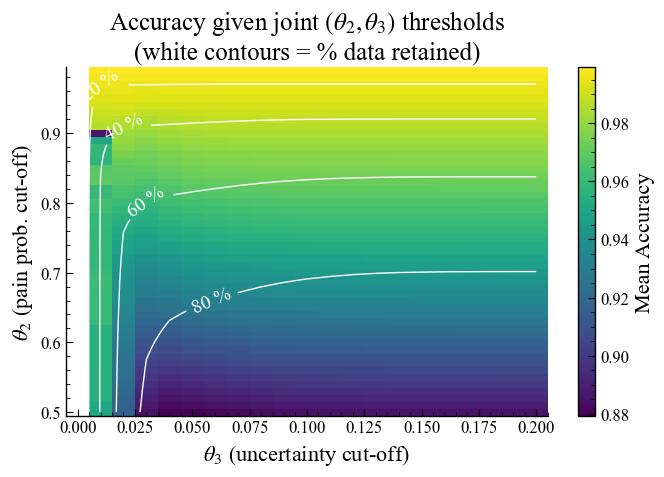

In [35]:
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------------
# 0.  GRID OF THRESHOLDS
# ------------------------------------------------------------------
theta2_pain   = np.arange(0.50, 1.00, 0.01)        # 0.50 … 0.95   (10 values)
theta2_nopain = 1.0 - theta2_pain                  # symmetric cut-off
theta3         = np.arange(0.0, dataframe_calib[mode].max()+1e-6, 0.01)  # ~100 values

T2, T3 = len(theta2_pain), len(theta3)
F       = len(unique_folds)

# ------------------------------------------------------------------
# 1.  PRE-ALLOCATE RESULT MATRICES  (fold × θ₂ × θ₃)
# ------------------------------------------------------------------
acc_folds     = np.full((F, T2, T3), np.nan, dtype=np.float32)
removed_folds = np.zeros((F, T2, T3), dtype=np.float32)

# ------------------------------------------------------------------
# 2.  LOOP OVER FOLDS  (inner threshold loops are small)
# ------------------------------------------------------------------
for f_idx, fold in enumerate(unique_folds):
    df      = dataframe_calib[dataframe_calib["fold"] == fold]
    probs   = df["probs"].to_numpy()          # (N,)
    preds   = df["preds"].to_numpy()
    labels  = df["labels"].to_numpy()
    uncert  = df[mode].to_numpy()             # std / entropy / etc.
    N       = len(df)

    # Pre-compute θ₂ keep mask: (N, T2)
    keep2 = (probs[:, None] >= theta2_pain) | (probs[:, None] <= (1.0 - theta2_pain))

    # Pre-compute θ₃ keep mask: (N, T3)
    keep3 = uncert[:, None] <= theta3

    for t2_idx in range(T2):
        mask2 = keep2[:, t2_idx]              # (N,)

        # Combine with all θ₃ at once → (N, T3)
        joint_keep = mask2[:, None] & keep3   # broadcast

        # Retained ratio per θ₃
        kept_frac  = joint_keep.mean(axis=0)  # (T3,)
        removed_folds[f_idx, t2_idx] = 1.0 - kept_frac

        # Accuracy per θ₃
        for t3_idx in range(T3):
            sel = joint_keep[:, t3_idx]
            if sel.any():
                acc_folds[f_idx, t2_idx, t3_idx] = validation_metrics(
                    preds[sel], probs[sel], labels[sel]
                )["Accuracy"]

# ------------------------------------------------------------------
# 3.  AGGREGATE ACROSS FOLDS
# ------------------------------------------------------------------
mean_acc     = np.nanmean(acc_folds,     axis=0)    # (T2, T3)
mean_removed = removed_folds.mean(axis=0)           # (T2, T3)

# ------------------------------------------------------------------
# 4.  PLOT: HEAT-MAP OF ACCURACY  +  RETAINED-DATA CONTOURS
# ------------------------------------------------------------------
X, Y = np.meshgrid(theta3, theta2_pain)             # X: θ₃,  Y: θ₂ (pain)

plt.figure(figsize=(7,5))
c = plt.pcolormesh(
    X, Y, mean_acc, shading="auto", cmap="viridis"
)
plt.colorbar(c, label="Mean Accuracy")

keep_ratio = 1.0 - mean_removed             # % data retained

# Choose increasing contour levels inside the valid range
levels = [0.2, 0.4, 0.6, 0.8]                    # 40 %, 60 %, 80 %

contours = plt.contour(
    X, Y, keep_ratio,
    levels=levels, colors="white", linewidths=1.0
)
plt.clabel(contours, fmt=lambda v: f"{int(v*100)} %", colors="white")

plt.xlabel(r"$\theta_3$ (uncertainty cut-off)")
plt.ylabel(r"$\theta_2$ (pain prob. cut-off)")
plt.title("Accuracy given joint $(\\theta_2, \\theta_3)$ thresholds\n"
          "(white contours = % data retained)")
plt.savefig(f"theta2_theta3_mesh_{model}.pdf", dpi=300)


In [36]:
import numpy as np
from sklearn.metrics import auc

def safe_auc(x, y):
    x, y = np.asarray(x), np.asarray(y)
    mask = ~np.isnan(x) & ~np.isnan(y)
    if not np.any(mask):
        raise ValueError("No valid points left after dropping NaNs.")
    x_clean, y_clean = x[mask], y[mask]
    order = np.argsort(x_clean)          # keep auc happy if x isn’t sorted
    return auc(x_clean[order], y_clean[order])





### $\theta_2$

c:\Users\leona\anaconda3\envs\doutorado\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\leona\anaconda3\envs\doutorado\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


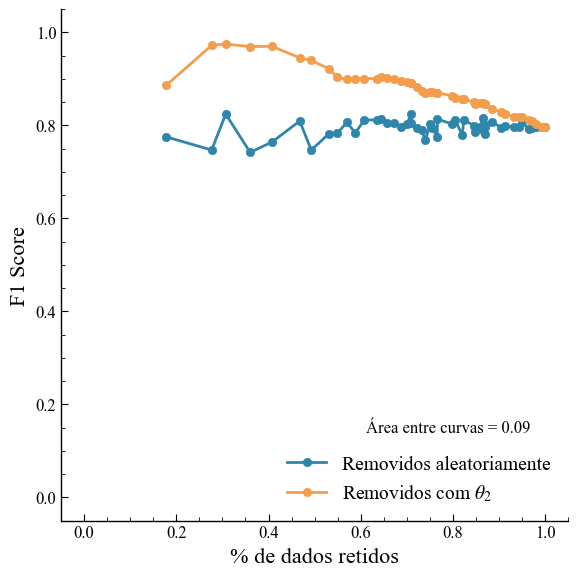

In [37]:
from turtle import color
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------------
# 0.  GRID & CONTAINERS
# ------------------------------------------------------------------
theta2_pain   = np.arange(0.50, 1.00, 0.01)         # 0.50 … 0.95
theta2_nopain = 1.0 - theta2_pain                   # symmetric cut-off
T2, F         = len(theta2_pain), len(unique_folds)

rng = np.random.default_rng(42)                     # reproducible baseline

metric_names = ["Accuracy", "F1 Score", "Precision",
                "Sensitivity", "Specificity", "AUC"]

# results  (shape: fold × θ₂)
removed_tot   = np.zeros((F, T2), dtype=np.float32)
metricsθ2     = {m: np.full_like(removed_tot, np.nan) for m in metric_names}
metrics_rand  = {m: np.full_like(removed_tot, np.nan) for m in metric_names}

# helpers
def _metric_dict(p, pr, y):
    try:
        return validation_metrics(p, pr, y)
    except ValueError:
        return {k: np.nan for k in metric_names}

rows_by_fold = {
    f: np.flatnonzero(dataframe_original["fold"].to_numpy() == f)
    for f in unique_folds
}

# ------------------------------------------------------------------
# 1.  SWEEP θ₂ (loop over folds, inner loop ≤ 10)
# ------------------------------------------------------------------
for f_idx, fold in enumerate(unique_folds):
    idx     = rows_by_fold[fold]
    df_o    = dataframe_original.iloc[idx]
    probs   = df_o["probs"].to_numpy()               # (N,)
    preds   = df_o["preds"].to_numpy()
    labels  = df_o["labels"].to_numpy()
    correct = (preds == labels)
    N       = len(idx)

    # keep mask for every θ₂  → shape (N, T2)
    keep = (probs[:, None] >= theta2_pain) | (probs[:, None] <= theta2_nopain)

    removed_tot[f_idx] = 1.0 - keep.mean(axis=0)

    for t2_idx in range(T2):
        mask = keep[:, t2_idx]
        if mask.any():
            m = _metric_dict(preds[mask], probs[mask], labels[mask])
            for k in metric_names:
                metricsθ2[k][f_idx, t2_idx] = m[k]

        # -------------- random baseline -----------------------------------
        n_drop   = int(removed_tot[f_idx, t2_idx] * N)
        rand_keep = np.ones(N, bool)
        if n_drop:                                # skip if 0 or 100 %
            rand_keep[rng.choice(N, n_drop, False)] = False

        m_r = _metric_dict(preds[rand_keep], probs[rand_keep], labels[rand_keep])
        for k in metric_names:
            metrics_rand[k][f_idx, t2_idx] = m_r[k]

# ------------------------------------------------------------------
# 2.  FOLD-MEANS  &  PLOT
# ------------------------------------------------------------------
mean_f1      = np.nanmean(metricsθ2["F1 Score"], axis=0)
mean_f1_rand = np.nanmean(metrics_rand["F1 Score"], axis=0)
mean_ret     = 1.0 - removed_tot.mean(axis=0)          # % kept

valid = ~(np.isnan(mean_ret) | np.isnan(mean_f1_rand) | np.isnan(mean_f1))
mean_ret_clean = mean_ret[valid]
mean_f1_rand_clean = mean_f1_rand[valid]
mean_f1_clean = mean_f1[valid]

auc_1 = safe_auc(mean_ret_clean, mean_f1_rand_clean)
auc_2 = safe_auc(mean_ret_clean, mean_f1_clean)
area_diff = np.abs(auc_1 - auc_2)

plt.plot(mean_ret_clean, mean_f1_rand_clean, "-o", label="Removidos aleatoriamente")
plt.plot(mean_ret_clean, mean_f1_clean,      "-o", label=r"Removidos com $\theta_2$")

#step = 10                                  # label every 2nd θ₂
#for i, (x, y, t) in enumerate(zip(mean_ret, mean_f1, theta2_pain)):
#    if i % step:                          # skip everything not divisible by step
#        continue
#    plt.annotate(f"[{t:.2f}; {1-t:.2f}]", xy=(x, y), xytext=(4, 4),
#                 textcoords="offset points",
#                 fontsize=9, ha="left", va="bottom",
#                 bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=.7))

#plt.fill_between(mean_ret, mean_f1, mean_f1_rand, color='#9E9E9E', alpha=0.5)

plt.annotate(f"Área entre curvas = {area_diff:.2f}", xy=(0.6, 0.12), xytext=(4, 4),
                 textcoords="offset points",
                 fontsize=12, ha="left", va="bottom",
                 bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=.7))


plt.xlabel("% de dados retidos")
plt.ylabel("F1 Score")
plt.legend(loc='lower right')
plt.ylim([-0.05, 1.05])
plt.xlim([-0.05, 1.05])
plt.savefig(f"random_remove_theta2_{model}.pdf", dpi=300, bbox_inches="tight")


### $\theta_3$

c:\Users\leona\anaconda3\envs\doutorado\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\leona\anaconda3\envs\doutorado\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\leona\anaconda3\envs\doutorado\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\leona\anaconda3\envs\doutorado\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\leona\anaconda3\envs\doutorado\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. 

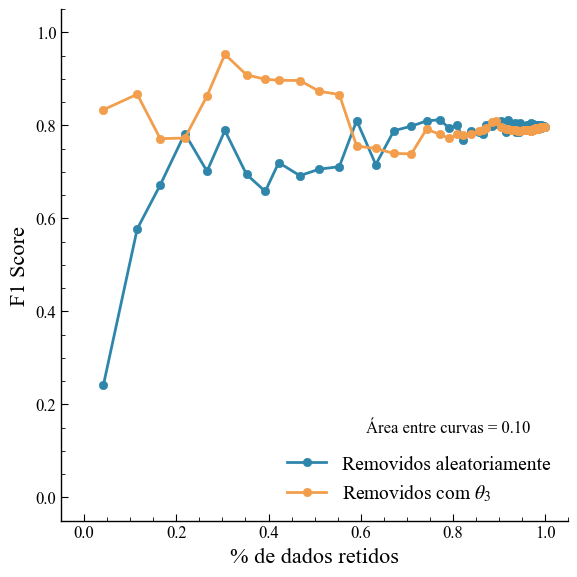

In [38]:
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------------
# 0.  set-up
# ------------------------------------------------------------------
theta3_grid = np.linspace(0.0, dataframe_original["stds"].max(), 100)
T3, F       = len(theta3_grid), len(unique_folds)
rng         = np.random.default_rng(42)               # reproducible baseline

metric_names = ["Accuracy", "F1 Score", "Precision",
                "Sensitivity", "Specificity", "AUC"]

# result containers  (fold axis = rows, θ₃ axis = cols)
removed_tot   = np.zeros((F, T3), dtype=np.float32)
removed_corr  = np.zeros_like(removed_tot)
removed_inc   = np.zeros_like(removed_tot)

metricsθ3     = {m: np.full_like(removed_tot, np.nan) for m in metric_names}
metrics_rand  = {m: np.full_like(removed_tot, np.nan) for m in metric_names}

# ------------------------------------------------------------------
# helpers
# ------------------------------------------------------------------
def _metric_dict(pred, prob, lab):
    try:
        return validation_metrics(pred, prob, lab)
    except ValueError:                       # array has one class only
        return {k: np.nan for k in metric_names}

rows_by_fold = {f: np.flatnonzero(dataframe_original["fold"].to_numpy() == f)
                for f in unique_folds}

# ------------------------------------------------------------------
# 1.  sweep θ₃   (loop over folds, inner loop ≤ 100 is tiny)
# ------------------------------------------------------------------
for f_idx, fold in enumerate(unique_folds):
    idx        = rows_by_fold[fold]
    df_o       = dataframe_original.iloc[idx]
    uncert     = df_o["stds"].to_numpy()           # (N,)
    preds      = df_o["preds"].to_numpy()
    probs      = df_o["probs"].to_numpy()
    labels     = df_o["labels"].to_numpy()
    correct    = (preds == labels)
    N          = len(idx)

    # keep-mask for every θ₃:  (N, T3)
    keep = uncert[:, None] <= theta3_grid          # broadcast

    # removal stats
    frac_kept      = keep.mean(axis=0)             # (T3,)
    removed_tot[f_idx] = 1.0 - frac_kept
    removed_corr[f_idx] = ( (~keep) &  correct[:, None]).sum(0) / correct.sum()
    removed_inc [f_idx] = ( (~keep) & (~correct)[:, None]).sum(0) / (~correct).sum()

    # metrics θ₃
    for t_idx in range(T3):
        mask = keep[:, t_idx]
        if mask.any():
            m = _metric_dict(preds[mask], probs[mask], labels[mask])
            for k in metric_names:
                metricsθ3[k][f_idx, t_idx] = m[k]

        # -------- random baseline (drop same # samples) ---------------------
        n_drop = int(removed_tot[f_idx, t_idx] * N)
        rand_keep = np.ones(N, bool)
        if n_drop:                               # skip if 0 or 100 %
            rand_keep[rng.choice(N, n_drop, False)] = False

        m_r = _metric_dict(preds[rand_keep], probs[rand_keep], labels[rand_keep])
        for k in metric_names:
            metrics_rand[k][f_idx, t_idx] = m_r[k]

# ------------------------------------------------------------------
# 2.  aggregate across folds
# ------------------------------------------------------------------
mean_f1      = np.nanmean(metricsθ3["F1 Score"], axis=0)
mean_f1_rand = np.nanmean(metrics_rand["F1 Score"], axis=0)
mean_ret     = 1.0 - removed_tot.mean(axis=0)          # % kept



valid = ~(np.isnan(mean_ret) | np.isnan(mean_f1_rand) | np.isnan(mean_f1))
mean_ret_clean = mean_ret[valid]
mean_f1_rand_clean = mean_f1_rand[valid]
mean_f1_clean = mean_f1[valid]

auc_1 = safe_auc(mean_ret_clean, mean_f1_rand_clean)
auc_2 = safe_auc(mean_ret_clean, mean_f1_clean)
area_diff = np.abs(auc_1 - auc_2)

# ------------------------------------------------------------------
# 3.  plot
# ------------------------------------------------------------------
plt.plot(mean_ret_clean, mean_f1_rand_clean, "-o", label="Removidos aleatoriamente")
plt.plot(mean_ret_clean, mean_f1_clean, "-o", label=r"Removidos com $\theta_3$")

#step = 10                                  # label every 2nd θ₂
#for i, (x, y, t) in enumerate(zip(mean_ret, mean_f1, theta3_grid)):
#    if i % step:                          # skip everything not divisible by step
#        continue
#    plt.annotate(f"{t:.2f}", xy=(x, y), xytext=(4, 4),
#                 textcoords="offset points",
#                 fontsize=9, ha="left", va="bottom",
#                 bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=.7))


#plt.fill_between(mean_ret, mean_f1, mean_f1_rand, color='#9E9E9E', alpha=0.5)

plt.annotate(f"Área entre curvas = {area_diff:.2f}", xy=(0.6, 0.12), xytext=(4, 4),
                 textcoords="offset points",
                 fontsize=12, ha="left", va="bottom",
                 bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=.7))

plt.xlabel('% de dados retidos')
plt.ylabel('F1 Score')
plt.legend(loc='lower right')
plt.ylim([-0.05, 1.05])
plt.xlim([-0.05, 1.05])
plt.savefig(f"random_remove_theta3_{model}.pdf", dpi=300, bbox_inches="tight")


## Theta_4 - XAI


## Vizu

In [ ]:
dataframe_original['theta_3'].mean()

In [ ]:
g = sns.jointplot(x="probs", y="stds", data=dataframe_original, hue='corrects',marginal_ticks=True, )

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------------------------------------------------
# 0 . CONSTANTS
# ---------------------------------------------------------------------
ALPHA_REMOVED = 0.30
COL_CORRECT   = "#0C5DA5"
COL_INCORRECT = "#FF9500"

theta2_upper  = 0.80
theta2_lower  = 0.20          # ← set as needed (use 0.00 if “one-sided”)
# theta_3 already defined earlier

# ---------------------------------------------------------------------
# 1 . PREPARE DATA  (same as before, but once)
# ---------------------------------------------------------------------
df = dataframe_original.copy()
df["is_correct"] = df["corrects"].astype(bool)
df["is_certain"] = df["stds"] <= 0.0570
df["is_precise"] = (df["probs"] >= theta2_upper) | (df["probs"] <= theta2_lower)
df["key"] = list(zip(df["is_correct"], df["is_certain"], df["is_precise"]))

lut = {
    (True , True , True ): dict(label="Resposta Correta",             a=1.0,  m="o", c=COL_CORRECT),
    (False, False, True ): dict(label="Resposta Incorreta",           a=1.0,  m="s", c=COL_INCORRECT),
    (True , False, False): dict(label="Resposta Correta Removida",    a=ALPHA_REMOVED, m="o", c=COL_CORRECT),
    (False, True , False): dict(label="Resposta Incorreta Removida",  a=ALPHA_REMOVED, m="s", c=COL_INCORRECT),
}

# ---------------------------------------------------------------------
# 2 . FIGURE (single axis)
# ---------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 6))

# Scatter by category
for key, props in lut.items():
    mask = df["key"] == key
    if mask.any():
        ax.scatter(df.loc[mask, "probs"],
                   df.loc[mask, "stds"],
                   s=65, edgecolors="k",
                   color=props["c"], marker=props["m"], alpha=props["a"],
                   label=props["label"])

# Horizontal line: θ₃
ax.hlines(0.0570, 0, 1, ls="--", color="k", lw=1.2)

# Vertical dashed lines: θ₂ limits
ax.vlines([theta2_lower, theta2_upper], ymin=0, ymax=df["stds"].max(),
          ls="--", color="k", lw=1.2)

ax.set_xlim(-0.05, 1.05)
ax.set_ylim(bottom=0)
ax.set_xlabel("Probabilidade Prevista")
ax.set_ylabel("Incerteza [$\\sigma$]")
ax.legend(frameon=False)
ax.set_title("Distribuição das Respostas vs. Incerteza\n"
             f"$\\theta_2=[{theta2_lower:.2f}, {theta2_upper:.2f}]$, "
             f"$\\theta_3={0.0570}$")


from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.image as mpimg
import random, pathlib

# ---------------------------------------------------------------------
# choose N examples per category (tweak as you like)
# ---------------------------------------------------------------------
N_PER_CAT = 3           # how many thumbnails per class to show
THUMB_SZ  = (48, 48)    # pixels

def _sample_paths(mask, n=N_PER_CAT):
    """Return up to n (x, y, path) tuples from df[mask]."""
    rows = df.loc[mask, ["probs", "stds", "img_names"]]
    if rows.empty:
        return []
    if len(rows) > n:
        rows = rows.sample(n, random_state=0)
    return list(rows.itertuples(index=False, name=None))

# gather samples from each of the four classes you already plotted
samples = []
for key in lut.keys():
    samples += _sample_paths(df["key"] == key)

# ---------------------------------------------------------------------
# add thumbnails
# ---------------------------------------------------------------------
for x, y, pth in samples:
    img_path = pathlib.Path("D:\\Doutorado\\Mestrado\\"+pth)
    if not img_path.is_file():
        continue  # skip missing files

    try:
        img_arr = mpimg.imread(img_path)
        # tiny helper: shrink longer dimension to THUMB_SZ
        h, w = img_arr.shape[:2]
        zoom = THUMB_SZ[0] / max(h, w)
        imagebox = OffsetImage(img_arr, zoom=zoom)
        ab = AnnotationBbox(imagebox, (x, y),
                            frameon=False,  # no bounding box
                            box_alignment=(0.5, 0.5),
                            pad=0.2)
        ax.add_artist(ab)
    except Exception as e:
        print(f"Could not load {img_path}: {e}")


plt.tight_layout()
plt.savefig("respostas_removidas.png", dpi=150, bbox_inches="tight")


In [ ]:
df